# The tagging machine

Again, this is just a copy of work done in Bachelor's thesis. Because we base our work on information about layout type of each frame, we had to understand how data was prepared.
NOTE: this code may not work and is not really intended to work - it's just for learning purposes.

# Docs

Enables:
- going forward one frame - Enter;
- going forward several frames (and backward);
- marking layout change;
- marking view change;
- marking layout type;

In [1]:
import torch
import torchvision as tv
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import numpy as np
from IPython import display
from copy import deepcopy
from time import sleep

OUTPUT_DIR = "../../data/TheLastLabels/"

In [2]:
test = False

In [5]:
%matplotlib inline

In [22]:
def tag(name):
    
    # Load the video
    vid = torch.load("../../data/Converted/" + name)
    
    # Create the view
    view = torch.zeros(vid.shape[0], dtype=torch.uint8)
    
    # Label dict
    label_dict = {
        'c': 1,
        's': 2,
        'lcc': 3,
        'lcs': 4,
        'lsc': 5,
        'lss': 6,
        'mcc': 7,
        'mcs': 8,
        'msc': 9,
        'mss': 10
    }

    # Initial Params
    message = 'Start'
    i = 0
    while True: # Main Loop

        ####### Display Image ######
        plt.clf()
        draw_frame(vid, view, i, message, 100*i/(vid.shape[0]-1))
        display.clear_output(wait=True)
        display.display(plt.gcf())

        ########## Input ###########

        # Input
        I = input()
        try:
            I = int(I)
        except: pass

        ######## Exit Loop #########

        # Break
        if I == 'exit':
            message = "exit"
            break

        ########## Layout ##########

        # Layout
        if I in label_dict:
            prev_label = deepcopy(view[i])
            view[i] = label_dict[I]
            fill_cur(view, i, prev_label)
            message = "added label"

        ######## Traversing #########

        # Next Frame
        elif I == '':
            if i == vid.shape[0]-1:
                message = "end of video"
            else:
                message = "next frame"
                i += 1

        # Jumping
        elif type(I) == int:

            # Keeping i in range
            if i + I < 0:
                I = i
                i = 0
            elif i + I >= vid.shape[0]:
                I = vid.shape[0] - 1 - i
                i = vid.shape[0] - 1
            else: 
                i += I

            message = f"Jumped {I} frames!"

        ######## Error ############

        # Try again
        else:
            message = "Error, command not understood. Try again!"
    
    # Close Plot
    plt.close()
    
    # Saving
    try:
        torch.save(view, OUTPUT_DIR + name)
    except e:
        print("An error occured while saving!")

# Fill

In [8]:
def fill(v):
    cur = v[0]
    for i in range(v.shape[0]):
        if v[i] == 0:
            v[i] = cur
        else:
            cur = v[i]

In [9]:
if test:
    a = torch.ByteTensor([1,0,0,0,2,0,0,0,3])
    fill(a)
    print(a)

In [10]:
def fill_cur(v, i, prev_label):
    if v[i] == 0:
        return
    else:
        cur = v[i]
        i += 1
        while i < v.shape[0] and v[i] == prev_label:
            v[i] = cur
            i += 1

In [11]:
if test:
    a = torch.ByteTensor([1,0,0,0,2,0,0,0,3])
    fill_cur(a, 0, 0)
    print(a)

In [12]:
if test:
    a = torch.ByteTensor([1,0,0,0,2,0,0,0,3])
    fill_cur(a, 4, 0)
    print(a)

In [13]:
if test:
    a = torch.ByteTensor([1,0,0,0,2,0,0,0,3])
    fill_cur(a, 8, 0)
    print(a)

In [14]:
if test:
    a = torch.ByteTensor([1,0,0,0,2,0,0,0,3])
    fill_cur(a, 1, 0)
    print(a)

# Drawing 

In [16]:
def draw_frame(vid, view, i, message='', percentage=0):
    
    label_list = [
        'Not Answered',
        'Camera',
        'Screen',
        'Left-Splited: Camera | Camera',
        'Left-Splited: Camera | Screen',
        'Left-Splited: Screen | Camera',
        'Left-Splited: Screen | Screen',
        'Middle-Splited: Camera | Camera',
        'Middle-Splited: Camera | Screen',
        'Middle-Splited: Screen | Camera',
        'Middle-Splited: Screen | Screen'
    ]
    
    # Plot Image Frame
    plt.imshow(vid[i])
    plt.title(f'Message: {message} \n Frame: {i} ({round(percentage,1)}%), Label: {label_list[view[i]]}')
    
    if view[i] != 0:
        
        # Draw Border
        plt.plot([0, vid.shape[2]-1, vid.shape[2]-1, 0, 0],
                 [0, 0, vid.shape[1]-1, vid.shape[1]-1, 0], c='r')
    
        if view[i] < 3: # Draw layout Full
            
            # Type:
            full_type = 'Camera' if view[i] == 1 else 'Screen'
            
            # Draw left Type
            plt.text(5*vid.shape[2]/12, vid.shape[1]/2, full_type, fontsize=14, c='r')
    
        elif view[i] < 7: # Draw Layout left

            # Draw Split
            plt.plot([.333 * vid.shape[2], .333 * vid.shape[2]], [0, vid.shape[1]-1], c='r')
            plt.plot([0, .333 * vid.shape[2]], [ .5 * vid.shape[1], .5 * vid.shape[1]], c='r')

            # Types:
            left_type  = 'Camera' if view[i] in [3,4] else 'Screen'
            right_type = 'Camera' if view[i] in [3,5] else 'Screen'
            
            
            # Draw left Type
            plt.text(vid.shape[2]/12, vid.shape[1]/4, left_type, fontsize=14, c='r')

            # Draw Right Type
            plt.text(7*vid.shape[2]/12, vid.shape[1]/2, right_type, fontsize=14, c='r')


        else: # Draw Layout Middle
            
            # Draw Split
            plt.plot([.5 * vid.shape[2], .5 * vid.shape[2]], [0, vid.shape[1]-1], c='r')

            # Types:
            left_type  = 'Camera' if view[i] in [7,8] else 'Screen'
            right_type = 'Camera' if view[i] in [7,9] else 'Screen'
            
            # Draw left Type
            plt.text(vid.shape[2]/6, vid.shape[1]/2, left_type, fontsize=14, c='r')
            
            # Draw Right Type
            plt.text(2*vid.shape[2]/3, vid.shape[1]/2, right_type, fontsize=14, c='r')

In [17]:
if test:
    view = torch.zeros(vid.shape[0], dtype=torch.uint8)
    view[2000] = 1
    draw_frame(vid, view, 2000, "asdf", 38.3)

# Tagging

In [20]:
l = os.listdir("../../data/Converted/")
l

['15S1-PH1105-LEC_20150824.pt',
 '17S2-MH1804-LEC_20180419.pt',
 '17S2-BS1102-LEC_20180116.pt',
 '15S1-PH1105-LEC_20150821.pt',
 '15S2-PH1106-LEC_20160203.pt',
 '17S1-CM1021-LEC_20170830.pt',
 '17S2-MH1811-LEC_20180212.pt',
 '16S1-PH1801-LEC_20161110.pt',
 '18S1-BS1101-LEC_20181019.pt',
 '17S2-BS1102-LEC_20180123.pt',
 '17S2-BS1102-LEC_20180118.pt',
 '18S1-MH1100-LEC_20181018.pt',
 '17S1-CM1021-LEC_20170818.pt',
 '15S1-MH1800-LEC_20150817.pt',
 '16S1-PH1104-LEC_20161110.pt',
 '16S2-MH1301-LEC_20170109.pt',
 '15S1-MH1812-LEC_20150917.pt',
 '17S2-BS1102-LEC_20180131.pt',
 'PH1011-PHYSICS_20150929.pt',
 '15S1-PH1104-LEC_20150820_PC1.pt',
 'PH1011-PHYSICS_20151013.pt',
 '16S1-PH1104-LEC_20161031.pt',
 '17S1-PH1011-LEC_20171017.pt',
 '15S2-PH1106-LEC_20160210.pt',
 '18S1-PH1801-LEC_20180907.pt',
 '17S1-MH1100-LEC_20170817.pt',
 '17S1-PH1801-LEC_20170907.pt',
 '17S2-BS1102-LEC_20180130.pt',
 '16S1-PH1801-LEC_20161020.pt',
 '17S2-CM1041-LEC_20180221.pt',
 '15S1-PH1105-LEC_20150817.pt',
 '18S1

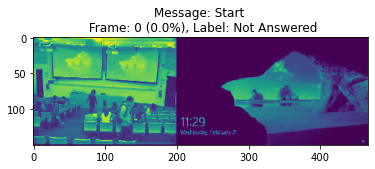

In [ ]:
tag(l[29])